# Pre Proccesing of the data

## Looking at the data 

I will styart by just exploring the data and trying to get familiar to it and see what I am working with. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image, ImageEnhance
import random
import hashlib
from tqdm import tqdm
import os
import cv2 as cv2

In [3]:
# Load the data
data_path = "/Users/michelangelozampieri/Downloads/bttai-ajl-2025/train/train"
categories = os.listdir(data_path)
# Remove .DS_Store from the list
categories.remove('.DS_Store')
for c in categories:
    print(c)

dyshidrotic-eczema
acne-vulgaris
acne
dermatomyositis
eczema
melanoma
basal-cell-carcinoma-morpheiform
malignant-melanoma
keloid
epidermal-nevus
squamous-cell-carcinoma
seborrheic-keratosis
basal-cell-carcinoma
mycosis-fungoides
kaposi-sarcoma
pyogenic-granuloma
actinic-keratosis
folliculitis
dermatofibroma
prurigo-nodularis
superficial-spreading-melanoma-ssm


In [4]:
# Get the count of each category and store results in a dataframe
image_counts = {category: len(os.listdir(os.path.join(data_path, category))) for category in categories}
df = pd.DataFrame(image_counts.items(), columns=['Category', 'Image Count'])    
print(df)        

                              Category  Image Count
0                   dyshidrotic-eczema           59
1                        acne-vulgaris          235
2                                 acne          129
3                      dermatomyositis          107
4                               eczema          144
5                             melanoma          182
6     basal-cell-carcinoma-morpheiform           44
7                   malignant-melanoma           79
8                               keloid          110
9                      epidermal-nevus           65
10             squamous-cell-carcinoma          408
11                seborrheic-keratosis           49
12                basal-cell-carcinoma          329
13                   mycosis-fungoides          128
14                      kaposi-sarcoma          110
15                  pyogenic-granuloma           80
16                   actinic-keratosis          123
17                        folliculitis          240
18          

Looking at a sample image

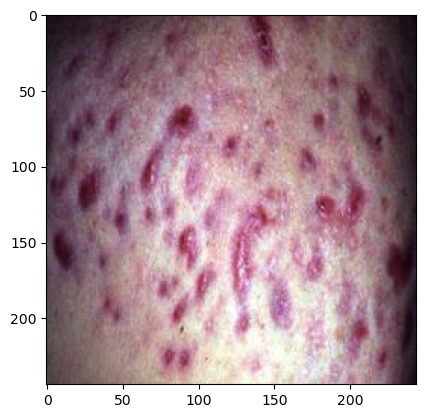

In [5]:
# Load an image
img = Image.open('/Users/michelangelozampieri/Downloads/bttai-ajl-2025/train/train/acne/0cff6f3c9bb267f68c77740fc9c58587.jpg')
plt.imshow(img)

Display a few random images for each label 

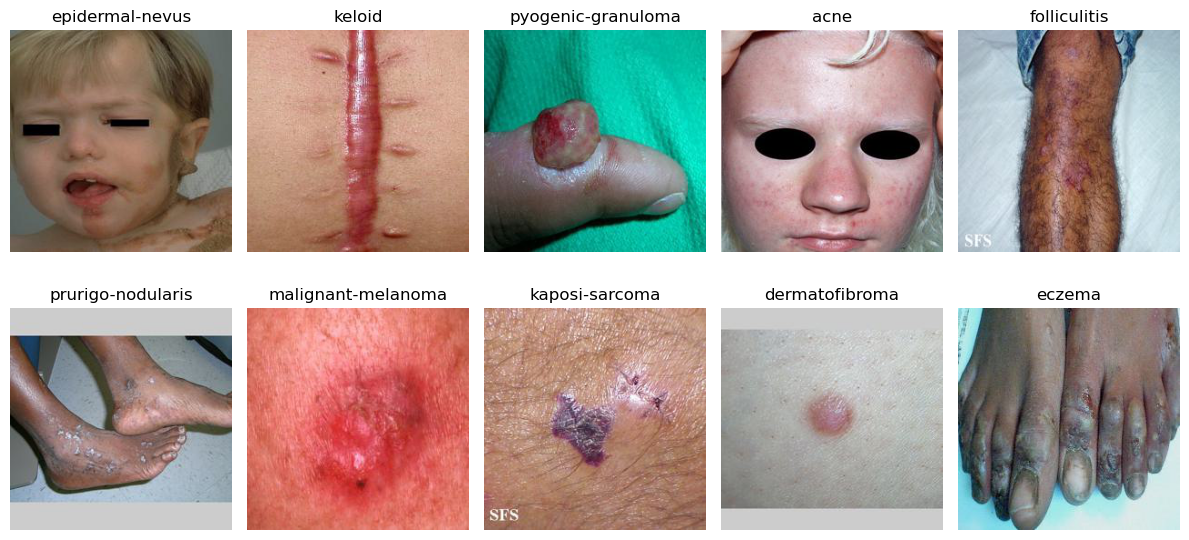

In [6]:
# Display random images from each category
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # Adjust as needed
for i, category in enumerate(random.sample(categories, min(10, len(categories)))):
    image_path = os.path.join(data_path, category, random.choice(os.listdir(os.path.join(data_path, category))))
    img = Image.open(image_path)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(category)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Image Augmentation

I will perform some image augemntation which will take existing images and flip, rotate, and slightly change the existing images to create more images to get a better training set for the data. 

In [7]:
def flip_UD(image_path):
    """Flip an image upside down and return the result"""
    img = Image.open(image_path)
    return img.transpose(Image.FLIP_TOP_BOTTOM)

def flip_LR(image_path):
    """Flip an image left to right and return the result"""
    img = Image.open(image_path)
    return img.transpose(Image.FLIP_LEFT_RIGHT)

def rotate(image_path, degrees):
    """Rotate an image and return the result"""
    img = Image.open(image_path)
    return img.rotate(degrees)

def adjust_brightness(image_path, factor=0.5):
    """Adjust the brightness and return the result"""
    img = Image.open(image_path)
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)

def adjust_contrast(image_path, factor=1.5):
    """Adjust the contrast and return the result"""
    img = Image.open(image_path)
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(factor)

def adjust_saturation(image_path, factor=1.5):
    """ADjust the saturation and return the result"""
    img = Image.open(image_path)
    enhancer = ImageEnhance.Color(img)
    return enhancer.enhance(factor)

def adjust_hue(image_path, factor=0.1):
    """Adjust the hue of an image and return the result"""
    img = Image.open(image_path).convert("RGB")  # Ensure RGB mode
    img = np.array(img)  # Convert to NumPy array
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # Convert from RGB to HSV

    hsv[..., 0] = (hsv[..., 0].astype(np.int16) + int(factor * 180)) % 180  # Adjust hue
    adjusted_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB) # Convert back to RGB
    return Image.fromarray(adjusted_img)

def save_image(img, original_path, output_dir, suffix):
    """Save the image to the output directory with a suffix"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    base_name = os.path.basename(original_path)
    name, ext = os.path.splitext(base_name)
    new_name = f"{name}_{suffix}{ext}"
    img.save(os.path.join(output_dir, new_name))


In [8]:
def augment(category, data_path):
    """Augment all images in a given directory and save them to a directory within the given directory"""
    category_dir = os.path.join(data_path, category)
    
    # Create a new directory within the category directory to store augmented images
    augmented_dir = os.path.join(category_dir, 'augmented')
    os.makedirs(augmented_dir, exist_ok=True)
    
    # For every file in the directory
    image_files = [f for f in os.listdir(category_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for file in tqdm(image_files, desc="Augmenting images"):
        file_path = os.path.join(category_dir, file)
        save_image(flip_UD(file_path), file_path, augmented_dir, "flip_Up_Down")
        save_image(flip_LR(file_path), file_path, augmented_dir, "flip_Left_Right")
        save_image(rotate(file_path, 90), file_path, augmented_dir, "rotate_90")
        save_image(rotate(file_path, 180), file_path, augmented_dir, "rotate_180")
        save_image(rotate(file_path, 270), file_path, augmented_dir, "rotate_270")
        save_image(adjust_brightness(image_path, factor=0.5), file_path, augmented_dir, "adjusted_brightness")
        save_image(adjust_contrast(image_path, factor=1.5), file_path, augmented_dir, "adjusted_contrast")
        save_image(adjust_saturation(image_path, factor=1.5), file_path, augmented_dir, "adjusted_saturation")
        save_image(adjust_hue(image_path, factor=0.1), file_path, augmented_dir, "adjusted_hue")


In [9]:
# Augment every other category except acne
for category in categories:
    if category != 'acne':
        augment(category, data_path)

Augmenting images: 100%|██████████| 83/83 [00:01<00:00, 61.13it/s]


In [10]:
# Count the images and stores results in a new dataframe. 
def count_images(directory):
    """Count the number of images in a directory"""
    return len([f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))])

In [11]:
def create_image_counts_dataframe(base_dir):
    """Create a DataFrame with counts of original and augmented images for each category"""
    data = []
    subdirs = [subdir for subdir in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, subdir))]
    
    for subdir in subdirs:
        input_dir = os.path.join(base_dir, subdir)
        original_count = count_images(input_dir)
        
        augmented_dir = os.path.join(input_dir, "augmented")
        if os.path.exists(augmented_dir):
            augmented_count = count_images(augmented_dir)
        else:
            augmented_count = 0
        
        total_count = original_count + augmented_count
        data.append([subdir, original_count, augmented_count, total_count])
    
    df = pd.DataFrame(data, columns=["Category", "Original Images", "Augmented Images", "Total Images"])
    return df

In [12]:
df = create_image_counts_dataframe(data_path)
print(df)

                              Category  Original Images  Augmented Images  \
0                   dyshidrotic-eczema               58               522   
1                        acne-vulgaris              234              2106   
2                                 acne              128               643   
3                      dermatomyositis              106               954   
4                               eczema              143              1287   
5                             melanoma              181              1629   
6     basal-cell-carcinoma-morpheiform               43               387   
7                   malignant-melanoma               78               702   
8                               keloid              109               981   
9                      epidermal-nevus               64               576   
10             squamous-cell-carcinoma              407              3663   
11                seborrheic-keratosis               48               432   

In [13]:
# Make sure that for each row the number of original images * 3 is equal to the number of augmented images and store true or false in a new cell
df["Augmented Correct"] = df["Original Images"] * 9 == df["Augmented Images"]
print(df)

                              Category  Original Images  Augmented Images  \
0                   dyshidrotic-eczema               58               522   
1                        acne-vulgaris              234              2106   
2                                 acne              128               643   
3                      dermatomyositis              106               954   
4                               eczema              143              1287   
5                             melanoma              181              1629   
6     basal-cell-carcinoma-morpheiform               43               387   
7                   malignant-melanoma               78               702   
8                               keloid              109               981   
9                      epidermal-nevus               64               576   
10             squamous-cell-carcinoma              407              3663   
11                seborrheic-keratosis               48               432   

In [14]:
# Ensure the 'Augmented Correct' column exists
if "Augmented Correct" not in df.columns:
	df["Augmented Correct"] = df["Original Images"] * 9 == df["Augmented Images"]

# Count the trues in Augmented Correct
correct_augmented = df["Augmented Correct"].sum()
print(f"Correctly augmented {correct_augmented} categories.")

Correctly augmented 20 categories.


In [15]:
# Count the total number of original and total images 
total_original_images = df["Original Images"].sum()
total_augmented_images = df["Augmented Images"].sum()
total_images = df["Total Images"].sum()

print(f"Total original images: {total_original_images}")
print(f"Total augmented images: {total_augmented_images}")
print(f"Total images: {total_images}")

Total original images: 2860
Total augmented images: 25231
Total images: 28091


Convert all images to be 224 x 224, this will make it easier to train the CNN. 

In [16]:
# Resize every image in every durectory and sub directory to be 244 x 244 pixels
def resize_images(directory, size):
    """Resize all images in a directory to the given size"""
    image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for file in tqdm(image_files, desc=f"Resizing images in {os.path.basename(directory)}"):
        file_path = os.path.join(directory, file)
        img = Image.open(file_path)
        img = img.resize((size, size))
        img.save(file_path)

def resize_all_images(base_dir, size):
    """Resize all images in a directory and subdirectories to the given size"""
    subdirs = [subdir for subdir in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, subdir))]
    for subdir in subdirs:
        subdir_path = os.path.join(base_dir, subdir)
        resize_images(subdir_path, size)
        augmented_dir = os.path.join(subdir_path, "augmented")
        if os.path.exists(augmented_dir):
            resize_images(augmented_dir, size)

In [17]:
resize_all_images(data_path, 244)

Resizing images in augmented: 100%|██████████| 1629/1629 [00:03<00:00, 532.69it/s]
Resizing images in basal-cell-carcinoma-morpheiform: 100%|██████████| 43/43 [00:00<00:00, 575.79it/s]
Resizing images in augmented: 100%|██████████| 1071/1071 [00:01<00:00, 589.72it/s]
Resizing images in superficial-spreading-melanoma-ssm: 100%|██████████| 83/83 [00:00<00:00, 610.26it/s]
Resizing images in augmented: 100%|██████████| 747/747 [00:01<00:00, 588.99it/s]


Check that the resizing worked and that all images are 244 x 244

In [18]:
# Check how many pictures in each directory are 244 x 244 pixels
def check_image_sizes(directory):
    """Check the size of all images in a directory and return the count of correctly sized images"""
    correct_size_count = 0
    image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for file in tqdm(image_files, desc=f"Checking image sizes in {os.path.basename(directory)}"):
        file_path = os.path.join(directory, file)
        img = Image.open(file_path)
        if img.size == (244, 244):
            correct_size_count += 1
    return correct_size_count

def check_all_image_sizes(base_dir):
    """Check the size of all images in a directory and subdirectories and update the dataframe"""
    correct_sizes = []
    subdirs = [subdir for subdir in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, subdir))]
    for subdir in subdirs:
        subdir_path = os.path.join(base_dir, subdir)
        correct_size_count = check_image_sizes(subdir_path)
        augmented_dir = os.path.join(subdir_path, "augmented")
        if os.path.exists(augmented_dir):
            correct_size_count += check_image_sizes(augmented_dir)
        correct_sizes.append(correct_size_count)
    
    df["Correct Size Images"] = correct_sizes

In [19]:
check_all_image_sizes(data_path)

Checking image sizes in augmented: 100%|██████████| 1629/1629 [00:00<00:00, 4438.12it/s]
Checking image sizes in basal-cell-carcinoma-morpheiform: 100%|██████████| 43/43 [00:00<00:00, 4141.43it/s]
Checking image sizes in augmented: 100%|██████████| 1071/1071 [00:00<00:00, 4352.08it/s]
Checking image sizes in superficial-spreading-melanoma-ssm: 100%|██████████| 83/83 [00:00<00:00, 4561.95it/s]
Checking image sizes in augmented: 100%|██████████| 747/747 [00:00<00:00, 4064.53it/s]


In [20]:
print(df)

                              Category  Original Images  Augmented Images  \
0                   dyshidrotic-eczema               58               522   
1                        acne-vulgaris              234              2106   
2                                 acne              128               643   
3                      dermatomyositis              106               954   
4                               eczema              143              1287   
5                             melanoma              181              1629   
6     basal-cell-carcinoma-morpheiform               43               387   
7                   malignant-melanoma               78               702   
8                               keloid              109               981   
9                      epidermal-nevus               64               576   
10             squamous-cell-carcinoma              407              3663   
11                seborrheic-keratosis               48               432   

In [21]:
df["All Correct Size"] = df["Total Images"] == df["Correct Size Images"]
print(df)

                              Category  Original Images  Augmented Images  \
0                   dyshidrotic-eczema               58               522   
1                        acne-vulgaris              234              2106   
2                                 acne              128               643   
3                      dermatomyositis              106               954   
4                               eczema              143              1287   
5                             melanoma              181              1629   
6     basal-cell-carcinoma-morpheiform               43               387   
7                   malignant-melanoma               78               702   
8                               keloid              109               981   
9                      epidermal-nevus               64               576   
10             squamous-cell-carcinoma              407              3663   
11                seborrheic-keratosis               48               432   

In [22]:
all_correct_size = df["All Correct Size"].sum()
print(f"All images are the correct size: {all_correct_size}")

All images are the correct size: 21


In [23]:
total_img_count = df["Total Images"].sum()
print(f"Total images: {total_img_count}")

total_aug_count = df["Augmented Images"].sum()
print(f"Total augmented images: {total_aug_count}")

total_original_count = df["Original Images"].sum()
print(f"Total original images: {total_original_count}")

Total images: 28091
Total augmented images: 25231
Total original images: 2860


Now we have a data set of 17160 images. From the original 2860, we increased the number of total images by 14300 images. We can start training a CNN using these as the data

In [24]:
# Check the sizes of 100 random images

def check_random_image_sizes(base_dir, num_images):
    """Check the size of a random sample of images in a directory and subdirectories"""
    subdirs = [subdir for subdir in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, subdir))]
    for subdir in subdirs:
        subdir_path = os.path.join(base_dir, subdir)
        image_files = [f for f in os.listdir(subdir_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        random_files = random.sample(image_files, min(num_images, len(image_files)))
        for file in random_files:
            file_path = os.path.join(subdir_path, file)
            img = Image.open(file_path)
            print(f"Image size for {file}: {img.size}")

In [25]:
check_random_image_sizes(data_path, 100)

Image size for f50168817eaa7d776ace972392be68d5.jpg: (244, 244)
Image size for 5658be93cb2d7ee5fad92f4b393d2917.jpg: (244, 244)
Image size for a11fa4d8d0b52ec8f124164d3632420f.jpg: (244, 244)
Image size for 759b1a463741c3f90caf140dfc6125c8.jpg: (244, 244)
Image size for 429e7d0f79e45f669b5b0d979e13b9be.jpg: (244, 244)
Image size for 53561badcf6844e4a38757620e1e6bee.jpg: (244, 244)
Image size for bef091f1f07aaf49a1ddf13d8ce54d14.jpg: (244, 244)
Image size for 29864b78ce1ecb22e47e6794e6c7d4f8.jpg: (244, 244)
Image size for 7a4b007f241c7d0d85e92e1b863f3753.jpg: (244, 244)
Image size for f62c7ff974948c4a025c75d36b5260f2.jpg: (244, 244)
Image size for 6bcec9b1dbf6e442f7e602fbb4a64c38.jpg: (244, 244)
Image size for 3947c54947fe664318cfa6acd90cc023.jpg: (244, 244)
Image size for 8b8c0230f817101df28847ca1b52dad4.jpg: (244, 244)
Image size for ba4a0518a8118b6af8613532bc0ff336.jpg: (244, 244)
Image size for 18eee27413f59dd3f25d8987e81ca91b.jpg: (244, 244)
Image size for 2f63ef3e3dd0f6e79cc726079